In [ ]:
# import sys
# sys.path.append('../selectdata/search_from_es')

In [ ]:
print(sys.path)

In [1]:
from elasticsearch import Elasticsearch
from get_data import twitter, epa, bom, health
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [3]:
es = Elasticsearch(
    'https://127.0.0.1:9200',
    verify_certs=False,
    basic_auth=('elastic', 'elastic'),
    request_timeout=60,
    ssl_show_warn=False
    )

In [4]:
city = "Melbourne"

In [5]:
epa_data = epa(es, start=3, end=14, city=city, size=2000)
# health_data = health(es, lga=city, size=700)
# bom_data = bom(es, start=3, end=3, size=700)
twitter_data = twitter(es, city=city, size=2000)

In [6]:
data_twitter = [item['_source'] for item in twitter_data]
twitter_df = pd.DataFrame(data_twitter)
print(twitter_df)

      sentiment  full_name language
0     -0.046512  Melbourne       en
1      0.000000  Melbourne       so
2      0.272727  Melbourne       en
3      0.000000  Melbourne       en
4      0.200000  Melbourne       en
...         ...        ...      ...
1995  -0.055556  Melbourne       en
1996   0.142857  Melbourne       en
1997  -0.571429  Melbourne       en
1998  -0.454545  Melbourne       en
1999   1.000000  Melbourne       de

[2000 rows x 3 columns]


In [ ]:
data_bom = [item['_source'] for item in bom_data]
bom_df = pd.DataFrame(data_bom)
print(bom_df)

In [ ]:
# for i in health_data:
#     print(i['_source'])
data_health = [item['_source'] for item in health_data]
health_df = pd.DataFrame(data_health)
print(health_df)

In [7]:
data_epa = [{**item['_source'], 'date': item['_index']} for item in epa_data]
epa_df = pd.DataFrame(data_epa)
print(epa_df)

         hour       siteName            coordinates  averageValue  \
0    01:00:00  Melbourne CBD  [-37.8073959, 144.97]         18.48   
1    05:00:00  Melbourne CBD  [-37.8073959, 144.97]         17.08   
2    08:00:00  Melbourne CBD  [-37.8073959, 144.97]         12.31   
3    06:00:00  Melbourne CBD  [-37.8073959, 144.97]          9.11   
4    03:00:00  Melbourne CBD  [-37.8073959, 144.97]         13.53   
..        ...            ...                    ...           ...   
255  18:00:00  Melbourne CBD  [-37.8073959, 144.97]          7.09   
256  19:00:00  Melbourne CBD  [-37.8073959, 144.97]          6.47   
257  21:00:00  Melbourne CBD  [-37.8073959, 144.97]          7.93   
258  22:00:00  Melbourne CBD  [-37.8073959, 144.97]          6.41   
259  23:00:00  Melbourne CBD  [-37.8073959, 144.97]          9.62   

    healthParameter healthAdvice                        date  
0             PM2.5         Good  epa-air-quality-2024-05-07  
1             PM2.5         Good  epa-air-qua

In [ ]:
#PM2.5 vs ASR
pm25_data = epa_df[epa_df['healthParameter'] == 'PM2.5']
pm25_data_aligned = pm25_data.head(len(health_df))  # Align data lengths for demonstration

plt.figure(figsize=(10, 6))
plt.scatter(pm25_data_aligned['averageValue'], health_df['ASR'][:len(pm25_data_aligned)], alpha=0.5)
plt.title('Relationship between PM2.5 Levels and ASR in '+ city)
plt.xlabel('PM2.5 Level')
plt.ylabel('ASR')
plt.grid(True)
plt.show()

# city_textbox = widgets.Text(
#     value='Melbourne',
#     description='City:',
#     disabled=False
# )

In [ ]:
# 定义一个绘图函数
def plot_pm25_asr(city):
    pm25_data = epa_df[epa_df['healthParameter'] == 'PM2.5']
    pm25_data_aligned = pm25_data.head(len(health_df))  # Align data lengths for demonstration

    plt.figure(figsize=(10, 6))
    plt.scatter(pm25_data_aligned['averageValue'], health_df['ASR'][:len(pm25_data_aligned)], alpha=0.5)
    plt.title(f'Relationship between PM2.5 Levels and ASR in {city}')
    plt.xlabel('PM2.5 Level')
    plt.ylabel('ASR')
    plt.grid(True)
    plt.show()

# 创建文本框和按钮，用于输入城市名称
city_textbox = widgets.Text(
    value='Melbourne',
    description='City:',
    disabled=False
)

# 创建一个按钮，当点击时更新图表
button = widgets.Button(description="Update Plot")

# 全局变量存储城市名称
city = ''

# 更新图表的函数
def on_button_clicked(b):
    global city  # 引用全局变量
    city = city_textbox.value  # 更新城市变量
    clear_output(wait=True)  # 清除旧的输出，并等待新的输出
    display(city_textbox, button)  # 重新显示输入框和按钮
    plot_pm25_asr(city)  # 绘制新的图表

# 按钮点击事件
button.on_click(on_button_clicked)

# 显示输入框和按钮
display(city_textbox, button)


In [ ]:
city

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# def prepare_and_merge_datasets(bom_df, epa_df):
#     """
#     Prepares and merges BOM and EPA dataframes based on the hour of the day.

#     Parameters:
#     - bom_df: DataFrame containing BOM data with a 'local_date_time' column.
#     - epa_df: DataFrame containing EPA data with an 'hour' column.

#     Returns:
#     - Merged DataFrame on hourly precision.
#     """
#     # Convert 'local_date_time' from BOM to datetime and extract the hour for merging
#     bom_df['hour'] = pd.to_datetime(bom_df['local_date_time'], format='%Y%m%d%H%M%S').dt.hour

#     # Convert 'hour' in EPA to datetime, and extract the hour
#     epa_df['hour'] = pd.to_datetime(epa_df['hour'], format='%H:%M:%S').dt.hour

#     # Merge on the 'hour' column
#     merged_df = pd.merge(bom_df, epa_df, on='hour', suffixes=('_bom', '_epa'))
    
#     return merged_df

def merge_bom_epa(bom_df, epa_df):
    """
    Prepares and merges BOM and EPA dataframes based on the precise datetime information.

    Parameters:
    - bom_df: DataFrame containing BOM data with a 'local_date_time' column.
    - epa_df: DataFrame containing EPA data with 'hour' and 'date' columns.

    Returns:
    - Merged DataFrame on precise datetime information.
    """
    # Convert 'local_date_time' in BOM to datetime format
    bom_df['local_date_time'] = pd.to_datetime(bom_df['local_date_time'], format='%Y%m%d%H%M%S')
    bom_df['date'] = bom_df['local_date_time'].dt.date
    bom_df['hour'] = bom_df['local_date_time'].dt.hour

    # Convert 'hour' and 'date' in EPA to datetime format
    epa_df['hour'] = pd.to_datetime(epa_df['hour'], format='%H:%M:%S').dt.hour
    epa_df['date'] = pd.to_datetime(epa_df['date'], format='epa-air-quality-%Y-%m-%d').dt.date

    # Merge on the 'date' and 'hour' columns
    merged_df = pd.merge(bom_df, epa_df, on=['date', 'hour'], suffixes=('_bom', '_epa'))
    
    return merged_df

def create_heatmap(data, weather_cols, air_quality_cols):
    """
    Creates a heatmap showing the correlation between specified weather conditions and air quality indices.

    Parameters:
    - data: DataFrame with merged weather and air quality data.
    - weather_cols: List of column names related to weather conditions.
    - air_quality_cols: List of column names related to air quality indices.
    """
    # Focus on relevant columns only
    relevant_data = data[weather_cols + air_quality_cols]
    
    # Compute the correlation matrix
    corr_matrix = relevant_data.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation between Weather Conditions and Air Quality Indices')
    plt.show()

# Example usage:
# Assume 'bom_df' and 'epa_df' are already loaded DataFrames with the appropriate columns.
# merged_df = prepare_and_merge_datasets(bom_df, epa_df)
# create_heatmap(merged_df, ['apparent_temperature', 'delta_temperature'], ['averageValue'])


In [ ]:
merged_df = prepare_and_merge_datasets(bom_df, epa_df)
print(merged_df)

In [ ]:
print(merged_df)

In [ ]:
# 定义相关天气条件和空气质量指标的列
weather_columns = ['apparent_temperature', 'delta_temperature', 'air_temperature', 'dew_point', 'wind_spd_kmh']
air_quality_columns = ['averageValue']

# 调用函数生成热力图
create_heatmap(merged_df, weather_columns, air_quality_columns)


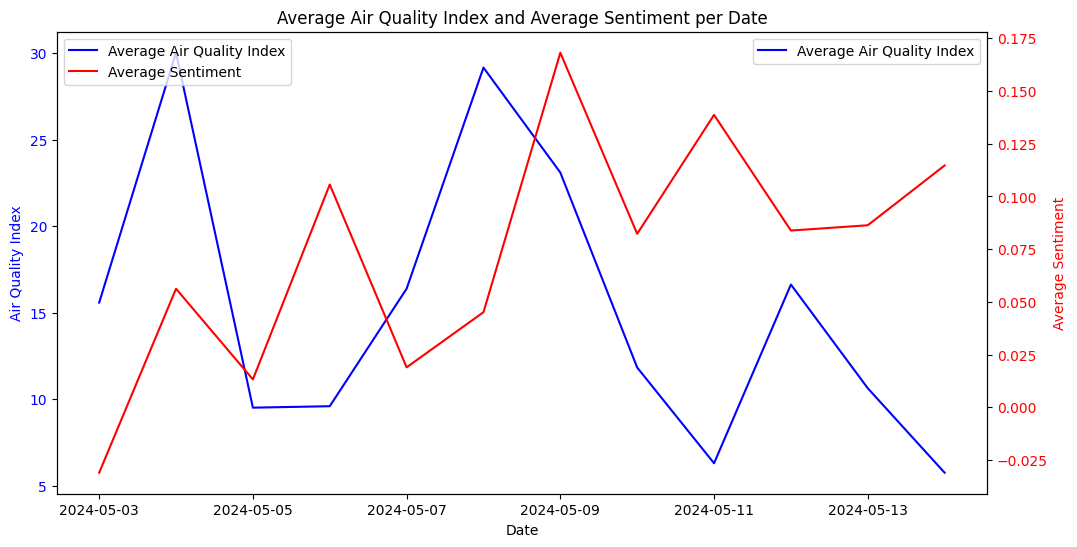

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming twitter_df and epa_df are already loaded as shown in your images

# Step 2: Ensure twitter_df matches the length of epa_df
if len(twitter_df) > len(epa_df):
    twitter_df = twitter_df.iloc[:len(epa_df)]
else:
    twitter_df = twitter_df.reindex(epa_df.index)

# Step 3: Reset the index to ensure concatenation is straightforward
twitter_df = twitter_df.reset_index(drop=True)
epa_df = epa_df.reset_index(drop=True)

# Step 4: Concatenate the dataframes side by side
concatenated_df = pd.concat([epa_df, twitter_df], axis=1)

# Step 5: Extract the date from the concatenated dataframe (EPA data column)
concatenated_df['date'] = pd.to_datetime(concatenated_df['date'], format='epa-air-quality-%Y-%m-%d').dt.date

# Step 6: Calculate the average sentiment and averageValue per date
avg_values_per_date = concatenated_df.groupby('date').agg({
    'sentiment': 'mean',
    'averageValue': 'mean'
}).reset_index()

# Step 7: Plot the data with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average air quality index on the first y-axis
sns.lineplot(data=avg_values_per_date, x='date', y='averageValue', ax=ax1, color='blue', label='Average Air Quality Index')
ax1.set_ylabel('Air Quality Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot the average sentiment scores
ax2 = ax1.twinx()
sns.lineplot(data=avg_values_per_date, x='date', y='sentiment', ax=ax2, color='red', label='Average Sentiment')
ax2.set_ylabel('Average Sentiment', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and labels
plt.title('Average Air Quality Index and Average Sentiment per Date')
ax1.set_xlabel('Date')

# Combine legends and place them outside the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1))

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [11]:
print(avg_values_per_date)

          date  sentiment  averageValue
0   2024-05-03  -0.031029     15.580833
1   2024-05-04   0.056216     30.025556
2   2024-05-05   0.013216      9.507917
3   2024-05-06   0.105644      9.591250
4   2024-05-07   0.018948     16.384771
5   2024-05-08   0.045101     29.165417
6   2024-05-09   0.168154     23.098333
7   2024-05-10   0.082262     11.828750
8   2024-05-11   0.138667      6.294348
9   2024-05-12   0.083818     16.623478
10  2024-05-13   0.086328     10.630435
11  2024-05-14   0.114677      5.746935


In [9]:
print(concatenated_df)

         hour       siteName            coordinates  averageValue  \
0    01:00:00  Melbourne CBD  [-37.8073959, 144.97]         18.48   
1    05:00:00  Melbourne CBD  [-37.8073959, 144.97]         17.08   
2    08:00:00  Melbourne CBD  [-37.8073959, 144.97]         12.31   
3    06:00:00  Melbourne CBD  [-37.8073959, 144.97]          9.11   
4    03:00:00  Melbourne CBD  [-37.8073959, 144.97]         13.53   
..        ...            ...                    ...           ...   
255  18:00:00  Melbourne CBD  [-37.8073959, 144.97]          7.09   
256  19:00:00  Melbourne CBD  [-37.8073959, 144.97]          6.47   
257  21:00:00  Melbourne CBD  [-37.8073959, 144.97]          7.93   
258  22:00:00  Melbourne CBD  [-37.8073959, 144.97]          6.41   
259  23:00:00  Melbourne CBD  [-37.8073959, 144.97]          9.62   

    healthParameter healthAdvice        date  sentiment  full_name language  
0             PM2.5         Good  2024-05-07  -0.046512  Melbourne       en  
1             P